In [4]:
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [5]:
def prepare(images, labels):
    images = images.astype('float32') / 255
    n, w, h = images.shape
    return images.reshape((n, w * h)), to_categorical(labels)

train, test = mnist.load_data()
x_train, y_train = prepare(*train)
x_test, y_test = prepare(*test)
img_width, img_height = train[0].shape[1:]

In [6]:
batch_size = 250
latent_space_depth = 2

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps


In [34]:
def VariationalAutoEncoder(num_pixels):
    pixels = Input(shape=(num_pixels,))
    encoder_hidden = Dense(512, activation='relu')(pixels)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return(0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1))

    def reconstruction_loss(y_true, y_pred):
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    
    decoder_hidden = Dense(512, activation='relu')

    reconstruct_pixels = Dense(num_pixels, activation='sigmoid')

    decoder_in = Input(shape=(latent_space_depth,))
    hidden = decoder_hidden(decoder_in)
    decoder_out = reconstruct_pixels(hidden)
    decoder = Model(decoder_in, decoder_out)    
    
    hidden = decoder_hidden(z)
    outputs = reconstruct_pixels(hidden)
    auto_encoder = Model(pixels, outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

auto_encoder, decoder = VariationalAutoEncoder(x_train.shape[1])
auto_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 512)          401920      input_17[0][0]                   
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 2)            1026        dense_32[0][0]                   
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 2)            1026        dense_32[0][0]                   
__________________________________________________________________________________________________
lambda_8 (

In [35]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

In [36]:
auto_encoder.fit(x_train, x_train, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 125us/step - loss: 214.1281 - KL_loss: 10.7052 - reconstruction_loss: 203.4229 - val_loss: 181.8244 - val_KL_loss: 5.3993 - val_reconstruction_loss: 176.4251
Epoch 2/100
60000/60000 [==============================] - 6s 101us/step - loss: 176.0493 - KL_loss: 4.8653 - reconstruction_loss: 171.1839 - val_loss: 170.5538 - val_KL_loss: 4.8051 - val_reconstruction_loss: 165.7487
Epoch 3/100
60000/60000 [==============================] - 7s 109us/step - loss: 168.2982 - KL_loss: 4.8428 - reconstruction_loss: 163.4554 - val_loss: 166.6530 - val_KL_loss: 4.8240 - val_reconstruction_loss: 161.8290
Epoch 4/100
60000/60000 [==============================] - 6s 106us/step - loss: 165.5347 - KL_loss: 4.9653 - reconstruction_loss: 160.5694 - val_loss: 164.8385 - val_KL_loss: 4.9888 - val_reconstruction_loss: 159.8497
Epoch 5/100
60000/60000 [==============================] - 7s 114us/step 

60000/60000 [==============================] - 8s 129us/step - loss: 149.1922 - KL_loss: 6.0761 - reconstruction_loss: 143.1161 - val_loss: 152.0566 - val_KL_loss: 6.2925 - val_reconstruction_loss: 145.7641
Epoch 39/100
60000/60000 [==============================] - 8s 128us/step - loss: 149.0389 - KL_loss: 6.0863 - reconstruction_loss: 142.9527 - val_loss: 151.9103 - val_KL_loss: 5.9954 - val_reconstruction_loss: 145.9149
Epoch 40/100
60000/60000 [==============================] - 9s 156us/step - loss: 148.9012 - KL_loss: 6.0979 - reconstruction_loss: 142.8032 - val_loss: 151.8481 - val_KL_loss: 5.9871 - val_reconstruction_loss: 145.8609
Epoch 41/100
60000/60000 [==============================] - 11s 180us/step - loss: 148.7529 - KL_loss: 6.0963 - reconstruction_loss: 142.6566 - val_loss: 151.6686 - val_KL_loss: 6.1352 - val_reconstruction_loss: 145.5333
Epoch 42/100
60000/60000 [==============================] - 9s 154us/step - loss: 148.6706 - KL_loss: 6.1164 - reconstruction_loss: 

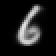

In [55]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height)).resize((56, 56))


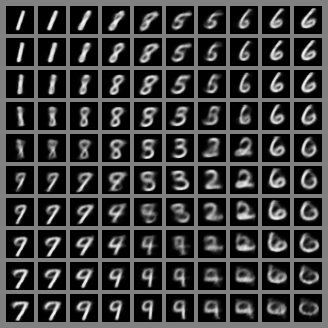

In [56]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth))
for x in range(num_cells):
    vec[:, 0] = (x * 3) / (num_cells - 1) - 1.5
    for y in range(num_cells):
        vec[:, 1] = (y * 3) / (num_cells - 1) - 1.5
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [20]:
def ConditionalVariationalAutoEncoder(num_pixels, num_labels):
    pixels = Input(shape=(num_pixels,))
    label = Input(shape=(num_labels,), name='label')

    inputs = concat([pixels, label], name='inputs')
    
    encoder_hidden = Dense(512, activation='relu', name='encoder_hidden')(inputs)

    z_mean = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return(0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1))

    def reconstruction_loss(y_true, y_pred):
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    zc = concat([z, label])
    
    decoder_hidden = Dense(512, activation='relu')

    reconstruct_pixels = Dense(num_pixels, activation='sigmoid')

    decoder_in = Input(shape=(latent_space_depth + num_labels,))
    hidden = decoder_hidden(decoder_in)
    decoder_out = reconstruct_pixels(hidden)
    decoder = Model(decoder_in, decoder_out)    
    
    hidden = decoder_hidden(zc)
    outputs = reconstruct_pixels(hidden)
    auto_encoder = Model([pixels, label], outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

cond_auto_encoder, cond_decoder = ConditionalVariationalAutoEncoder(x_train.shape[1], y_train.shape[1])
cond_auto_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
inputs (Concatenate)            (None, 794)          0           input_15[0][0]                   
                                                                 label[0][0]                      
__________________________________________________________________________________________________
encoder_hidden (Dense)          (None, 512)          407040      inputs[0][0]                     
__________

In [57]:
cond_auto_encoder.fit([x_train, y_train], x_train, verbose=1, 
                      batch_size=batch_size, epochs=50,
                      validation_data = ([x_test, y_test], x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 105us/step - loss: 129.1885 - KL_loss: 4.7397 - reconstruction_loss: 124.4489 - val_loss: 130.7288 - val_KL_loss: 4.5935 - val_reconstruction_loss: 126.1352
Epoch 2/50
60000/60000 [==============================] - 6s 107us/step - loss: 129.1577 - KL_loss: 4.7555 - reconstruction_loss: 124.4022 - val_loss: 130.6913 - val_KL_loss: 4.6928 - val_reconstruction_loss: 125.9985
Epoch 3/50
60000/60000 [==============================] - 6s 105us/step - loss: 129.0916 - KL_loss: 4.7557 - reconstruction_loss: 124.3359 - val_loss: 130.5601 - val_KL_loss: 4.6938 - val_reconstruction_loss: 125.8663
Epoch 4/50
60000/60000 [==============================] - 6s 107us/step - loss: 129.0676 - KL_loss: 4.7525 - reconstruction_loss: 124.3151 - val_loss: 130.6311 - val_KL_loss: 4.6708 - val_reconstruction_loss: 125.9603
Epoch 5/50
60000/60000 [==============================] - 7s 113us/step - loss

60000/60000 [==============================] - 8s 130us/step - loss: 127.8158 - KL_loss: 4.8745 - reconstruction_loss: 122.9413 - val_loss: 130.3383 - val_KL_loss: 4.9415 - val_reconstruction_loss: 125.3968
Epoch 39/50
60000/60000 [==============================] - 8s 128us/step - loss: 127.7705 - KL_loss: 4.8669 - reconstruction_loss: 122.9036 - val_loss: 130.3126 - val_KL_loss: 4.8402 - val_reconstruction_loss: 125.4724
Epoch 40/50
60000/60000 [==============================] - 7s 122us/step - loss: 127.7746 - KL_loss: 4.8919 - reconstruction_loss: 122.8827 - val_loss: 130.2123 - val_KL_loss: 4.8112 - val_reconstruction_loss: 125.4010
Epoch 41/50
60000/60000 [==============================] - 7s 117us/step - loss: 127.7435 - KL_loss: 4.8887 - reconstruction_loss: 122.8547 - val_loss: 130.2400 - val_KL_loss: 4.8042 - val_reconstruction_loss: 125.4357
Epoch 42/50
60000/60000 [==============================] - 7s 117us/step - loss: 127.7260 - KL_loss: 4.8902 - reconstruction_loss: 122.8

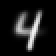

In [58]:
number_4 = np.zeros((1, latent_space_depth + y_train.shape[1]))
number_4[:, 4 + latent_space_depth] = 1
decode_img(cond_decoder.predict(number_4).reshape(
               img_width, img_height)).resize((56, 56))

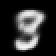

In [59]:
number_8_3 = np.zeros((1, latent_space_depth + y_train.shape[1]))
number_8_3[:, 8 + latent_space_depth] = 0.5
number_8_3[:, 3 + latent_space_depth] = 0.5
decode_img(cond_decoder.predict(number_8_3).reshape(
               img_width, img_height)).resize((56, 56))

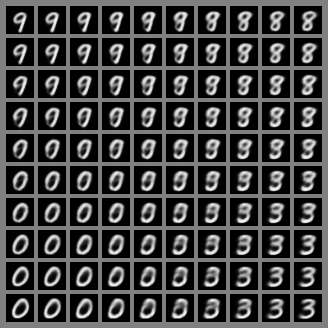

In [25]:
digits = [3, 0, 8, 9]
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
for x in range(num_cells):
    x1 = [x / (num_cells - 1), 1 - x / (num_cells - 1)]
    for y in range(num_cells):
        y1 = [y / (num_cells - 1), 1 - y / (num_cells - 1)]
        for idx, dig in enumerate(digits):
            vec[:, dig + latent_space_depth] = x1[idx % 2] * y1[idx // 2]
        decoded = cond_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

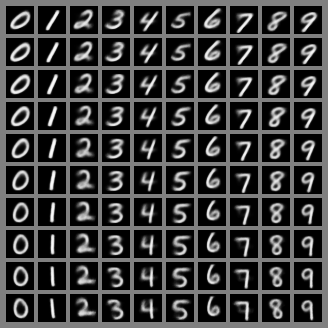

In [31]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

img_it = 0
vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
for x in range(num_cells):
    vec = np.zeros((1, latent_space_depth + y_train.shape[1]))
    vec[:, x + latent_space_depth] = 1
    for y in range(num_cells):
        vec[:, 1] = 3 * y / (num_cells - 1) - 1.5
        decoded = cond_decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview